# **REINFORCEMENT LEARNING PROJECT - ADVANTAGE ACTOR CRITIC AGENT**

In [ ]:
## INSTALLATIONS.
!sudo apt update
!sudo apt install -y build-essential autoconf libtool pkg-config python3-dev \
    python3-pip python3-numpy git flex bison libbz2-dev

!wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | sudo apt-key add -
!sudo apt-add-repository 'deb https://apt.kitware.com/ubuntu/ bionic main'
!sudo apt-get update && apt-get --allow-unauthenticated install -y \
    cmake \
    kitware-archive-keyring

# feel free to use a more elegant solution to make /usr/bin/cmake the default one
!sudo rm $(which cmake)
!$(which cmake) --version

# install nle and minihack
!pip install nle
!pip install minihack

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,554 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubu

In [ ]:
## LIBRARIES
import os
import gym
import math
import torch
import random
import imageio
import minihack
import numpy as np
from model import ActorCritic
from gym import spaces
from nle import nethack
from google.colab import drive
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
from minihack import RewardManager

Code was adapted from [Here](https://github.com/raillab/dqn) and modified to fit our requirements.

In [ ]:
# 1. Mount google drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# 2. Set device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **1. HELPER FUNCTIONS**

In [ ]:
def display_image(state):
  """Displays the image of state['pixel']."""
  img = np.uint8(state['pixel'])
  plt.figure(figsize=(15, 7))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [ ]:
def moving_average(arr, n):
  """Calculates the moving average of an array arr, with a window size n"""
  cummulative_sum = np.cumsum(arr, dtype=float)
  cummulative_sum[n:] = cummulative_sum[n:] - cummulative_sum[:-n]
  return cummulative_sum / n

In [ ]:
def format_state(state):
  """Formats the state into form that the CNN can accept"""
  glyphs = state["glyphs"]
  glyphs = glyphs / glyphs.max() # Standardize the glyphs
  glyphs = glyphs.reshape((1, 1, 21, 79)) # reshape
  message = state["message"]

  # check if max of the message state is greater than 0 to standardize.
  if state["message"].max() > 0:
    message = message / message.max() # Standardize the message
  message = message.reshape((1, len(message))) # reshape
  state = {"glyphs": glyphs, 
           "message": message}
  return state

In [ ]:
def compute_returns(rewards, gamma):
  """Computes the discounted returns of a sequence of rewards achieved in a trajectory"""
  returns = []
  r = 0
  for reward in rewards[::-1]:
    r = reward + (gamma * r)
    returns.append(r)
  returns.reverse()
  returns = np.array(returns)
  
  # Standardize Returns
  if np.mean(returns) != 0:
      returns = returns - np.mean(returns)
  if np.std(returns) != 0:
    returns = returns / np.std(returns)
  return returns

In [ ]:
def plot_results(scores):
  """
  Plots the reward acquired by an agent at each step of training in 
  an environment for each iteration and average over all iterations
  """
  
  plt.figure(figsize=(8, 6))
  
  # Plot the scores 
  for score in scores:
      plt.plot(score, color='blue', label='Learning curve')
  
  plt.title("A2C - Learning curve")
  plt.xlabel("Episode Number")
  plt.ylabel("Reward")
  plt.legend()
  plt.savefig('A2C-learning curve')
  plt.show()

## **2. TRAIN A2C AGENT**

In [ ]:
def train_a2c_agent(env, model, seed):
  """
  Method to train Actor Critic model.
  
  Input:
  env: The environment to be used during training
  seed: The random seed for any random operations performed
  
  Returns:
  policy: The neural network model after training that approximates the state value functions and action probabilities
  scores: The cumulative reward achieved by the agent for each episode during traiing
  """

  hyper_params = {
    'learning-rate': 0.02, # learning rate
    'gamma': 0.99,  # discount factor
    'number_episodes': int(5e3),  # number of episodes
    'max_episode_length': 1000, # episode length
    }

  # Setting random seeds (for reproducibility)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  env.seed(seed)
  
  # Initialize optimizer for Actor Critic Network
  optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning-rate'])
  # List to store the rewards attained in each episode
  scores = []
  
  for i in range(hyper_params['number_episodes']):
    # Reset environment
    state = format_state(env.reset())
    # Flag to see if episode has terminated
    done = False
    
    # Lists to store the rewards acquired, the log_probability of the actions and
    # the value function of the states visited in this episode 
    rewards = []
    log_probs = []
    state_values = []
    
    for t in range(1, hyper_params['max_episode_length']):
        
        # Get the probability distribution over actions and 
        # estimated state value function from Actor Critic network 
        action_probs,state_value = model.forward(state)
        distribution = torch.distributions.Categorical(action_probs)

        # Sample from the probability distribution to determine which action to take 
        action = distribution.sample()
        
        # Take selected action, observe the reward received, the next state 
        # and whether or not the episode terminated 
        next_state, reward, done, _ = env.step(action.item())
        next_state = format_state(next_state)

        # Store the reward, log of the probability of the action selected 
        # And
        rewards.append(reward)
        log_probs.append(distribution.log_prob(action))
        state_values.append(state_value)
        state = next_state
        if done:
            break
    
    # Store the reward acquired in the episode and calculate the discounted return of the episode
    scores.append(np.sum(rewards))
    returns = compute_returns(rewards, hyper_params['gamma'])
    returns = torch.from_numpy(returns).float().to(device)
    
    # Print the episode, the reward acquired in the episode and the mean reward over the last 50 episodes
    # print("Episode:", i, "Reward:", np.sum(rewards), "Average Reward:", np.mean(scores[-50:]), "Steps", t)
    mean_50ep_reward = round(np.mean(scores[-50:]), 1)
    print('********************************************************')
    print('steps: {}'.format(t))
    print('episodes: {}'.format(i))
    print('Episode Reward: {}'.format(np.sum(rewards)))
    print('mean 50 episode reward: {}'.format(mean_50ep_reward))
    print('********************************************************')
    
    # Calculate the loss for the episode and use it to update the network parameters 
    loss = 0
    for logprob, value, reward in zip(log_probs, state_values, returns):
      advantage = reward  - value.item()
      action_loss = -logprob * advantage
      try:
        reward = reward.resize(1, 1)
      except: pass
      value_loss = F.smooth_l1_loss(value, reward)
      loss += (action_loss + value_loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
  
    # save the model or policy network to google drive
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/RL PROJECT/a2c-checkpoint-{seed}.pth')

  # Store the policy as the neural network model at the final iteration
  policy = model
  return policy, scores

In [ ]:
# Reward for exploring more of the map
def maze_explore_reward_fn(env, prev_obs, action, next_obs):
  if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
    return 0.1
  return 0

In [ ]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP,
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF,
    nethack.Command.PRAY
    )

reward_manager = RewardManager()

# 1. Reward killing monster
reward_manager.add_kill_event("minotaur", reward=5, repeatable=False)

# 2. Random reward included to prevent reward glitch 
reward_manager.add_eat_event("apple", reward=1)

# 3. Custom rewards for long corridors at top and bottom 
reward_manager.add_coordinate_event((3,27), reward = -10, terminal_required = False)
reward_manager.add_coordinate_event((3,28), reward = -10, terminal_required = False)
reward_manager.add_coordinate_event((3,29), reward = -10, terminal_required = False)

reward_manager.add_coordinate_event((19,27), reward = -10, terminal_required = False)
reward_manager.add_coordinate_event((19,28), reward = -10, terminal_required = False)
reward_manager.add_coordinate_event((19,29), reward = -10, terminal_required = False)

# 4. Reward for reaching the first door at end of maze
reward_manager.add_coordinate_event((11,27), reward = 10, terminal_required = False)
reward_manager.add_custom_reward_fn(maze_explore_reward_fn)

In [ ]:
# 5. Make the environment.
env = gym.make("MiniHack-Quest-Hard-v0", observation_keys=["glyphs","pixel","message"],
               reward_win=100, reward_lose=-1, actions=NAVIGATE_ACTIONS, reward_manager=reward_manager)

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (21, 79)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN:

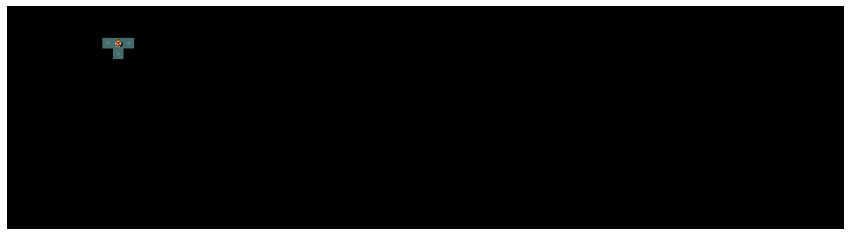

In [ ]:
# 6. Reset the environment and display the screen of the starting state
display_image(env.reset())

In [ ]:
# 7. Train the A2C Agent using diffrent seeds.
seeds = np.random.randint(100, size=1)
scores_array = []

for seed in seeds:
  print('=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~')
  print('seed:', seed)
  print('=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~')
  
  # Initialize the Actor Critic Model 
  ac_model = ActorCritic(h_size=512, a_size=env.action_space.n)
  
  # Train the Actor Critic Model 
  policy, scores = train_a2c_agent(env=env, model= ac_model, seed=seed)
  
  # Store rewards for this iteration 
  scores_array.append(scores)

  # Store rewards after each seed into binary file.
  np.save('/content/gdrive/MyDrive/RL PROJECT/a2c-quest_hard_scores', scores_array)

=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~
seed: 96
=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~


/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


********************************************************
steps: 114
episodes: 0
Episode Reward: -0.6799999999999999
mean 50 episode reward: -0.7
********************************************************


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Streaming output truncated to the last 5000 lines.
mean 50 episode reward: 0.7
********************************************************
********************************************************
steps: 24
episodes: 4167
Episode Reward: -0.18
mean 50 episode reward: 0.7
********************************************************
********************************************************
steps: 26
episodes: 4168
Episode Reward: 0.05000000000000003
mean 50 episode reward: 0.7
********************************************************
********************************************************
steps: 96
episodes: 4169
Episode Reward: 0.73
mean 50 episode reward: 0.7
********************************************************
********************************************************
steps: 89
episodes: 4170
Episode Reward: 0.8199999999999998
mean 50 episode reward: 0.7
********************************************************
********************************************************
steps: 57
episodes: 4171


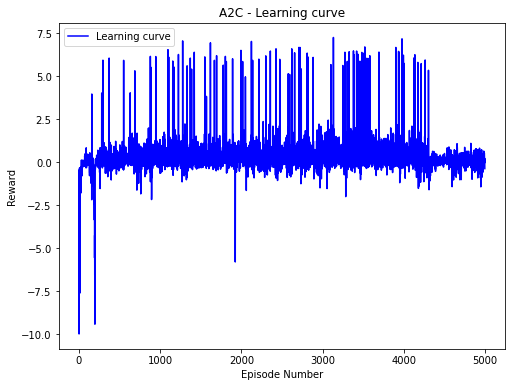

In [ ]:
# 1. load the scores and display the rewards over time.
quest_hard_scores = np.load("/content/gdrive/MyDrive/RL PROJECT/a2c-quest_hard_scores.npy", allow_pickle=True)
plot_results(scores=quest_hard_scores)

In [ ]:
# 2. initialize the environment
env = gym.make("MiniHack-Quest-Hard-v0", observation_keys=["glyphs","pixel","message"],
               reward_win=100, reward_lose=-1, actions=NAVIGATE_ACTIONS, reward_manager=reward_manager)

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (21, 79)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN:

In [ ]:
# 3. load the saved policy model to generate the video
model = ActorCritic(h_size=512, a_size=env.action_space.n)
model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/RL PROJECT/a2c-checkpoint-{seeds[0]}.pth'))
model.eval()

ActorCritic(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=128, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (relu5): ReLU()
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (relu6): ReLU()
  (value_layer): Linear(in_features=128, out_features=1, bias=True)
  (action_layer): Linear(in_features=128, out_features=18, bias=True)
  (softmax): Softmax(dim=-1)
)

In [ ]:
# 4. initialise the state and images to create a gif
state = env.reset()
images = []
images.append(np.uint8(state['pixel']))
count = 0
cum_reward = 0

# continue until we terminate the game.
while True:
    # NB: No epxloration
    # initialize action to be random.
    action = env.action_space.sample()

    # standardize the state
    state = format_state(state)
    
    # get the best action according to the trained policy network.
    action_probs, state_value = model.forward(state)
    distribution = torch.distributions.Categorical(action_probs)
    action = torch.argmax(distribution.probs).item()
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    if done:
        break
    count += 1
    images.append(np.uint8(state['pixel']))
imageio.mimsave('/content/gdrive/MyDrive/RL PROJECT/a2c_agent.gif', images)
print('Number of Steps Taken:', count)
print('Total Reward:', cum_reward)

Number of Steps Taken: 999
Total Reward: -9.769999999999836


In [ ]:
## 5. Display the GIF
Image(filename='/content/gdrive/MyDrive/RL PROJECT/a2c_agent.gif')

Output hidden; open in https://colab.research.google.com to view.